## Set libraries

In [53]:
import numpy as np
import xarray as xr
import rasterio
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import os
import datetime
import pandas as pd
import seaborn as sns
from rasterio_to_xarray import rasterio_to_xarray, xarray_to_rasterio
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from scipy import stats
import pylab

## Function which extracts the date information from filename to be used as a 'time' dimension label for each image
- load MAIAC data in using the rasterio_to_xarray function (Wilson,...)
- extract date and time information from the filename of the MAIAC images
- use the datetime library to strip the time and convert into the necessary format, specifying the format the date/time is currently in

In [ ]:
def maiac_file_to_da(filename):
    da = rasterio_to_xarray(filename)
    
    time_str = os.path.basename(filename)[17:-13]
    time_obj = datetime.datetime.strptime(time_str, '%Y%j%H%M')
    da.coords['time'] = time_obj
    
    return da

# Extract AOT MAIAC data for Chilbolton Pixel
- specify the folders in which the AOT data are in
- Create a for loop which goes through each year's folder one by one
    - Create a list of the files within the folder
    - run the maiac_file_to_da function on each element of the list
    - Make the MAIAC data three dimensional, with time as the third dimension
    - Order the data by time
    - Select data for Chilbolton Pixel and save measurements in a dataframe
    - Save the dataframe of the measurements as a csv, using the append mode

In [ ]:
folders = glob.glob(r'D:\MAIAC_Data\Europe\h00v01\Projected\20*')

In [ ]:
for folder in folders:
    files = glob.glob(r'{fname}\*_proj.tif'.format(fname=folder))
    list_of_das = map(maiac_file_to_da, files)
    MAIAC_AOT = xr.concat(list_of_das, 'time')
    MAIAC_AOT.attrs.clear()
    reordered_MAIAC_AOT = MAIAC_AOT.isel(time=np.argsort(MAIAC_AOT.time))
    Measurements = reordered_MAIAC_AOT.isel(x=1103, y=1027).dropna('time').to_dataframe(name='MAIAC_AOT')
    Measurements.to_csv(r'D:\Annies_Dissertation\Methodology\Validation\AERONET\Test\Alldata.csv', mode='a')
    print('Processed {fname}'.format(fname=folder))

## Read in MAIAC data
- Convert date into correct format
- Divide AOT/1000, as Lyapustin et al (2011a) multipled the AOT information in the MAIAC images by 1000, as through not saving the data as float, the storage size was significantly reduced. 

In [2]:
MAIAC = pd.read_csv(r'D:\Annies_Dissertation\Methodology\Validation\AERONET\Test\Alldata_FINAL.csv')

In [3]:
MAIAC[:10]

,Time,x,y,AOT
0,25/02/2000 10:50,138808.1057,438327.3471,83
1,26/02/2000 11:35,138808.1057,438327.3471,164
2,12/03/2000 12:30,138808.1057,438327.3471,205
3,15/03/2000 11:25,138808.1057,438327.3471,186
4,22/03/2000 11:30,138808.1057,438327.3471,591
5,06/04/2000 10:45,138808.1057,438327.3471,331
6,07/04/2000 11:30,138808.1057,438327.3471,210
7,08/04/2000 10:35,138808.1057,438327.3471,311
8,08/04/2000 12:15,138808.1057,438327.3471,319
9,10/04/2000 12:00,138808.1057,438327.3471,149


In [4]:
MAIAC['timestamp'] = pd.to_datetime(MAIAC.Time, format='%d/%m/%Y %H:%M')

In [5]:
MAIAC = MAIAC.set_index('timestamp')

In [6]:
MAIAC['AOT_New']= MAIAC.AOT/1000

In [7]:
MAIAC['timestamp'] = MAIAC.index

In [8]:
MAIAC = MAIAC.drop_duplicates(subset='timestamp')

In [9]:
MAIAC = MAIAC.sort_index()

# Read in AERONET data file into pandas DataFrame
The read_aeronet function provided by Wilson (2016) Robins Blog: Reading AERONET data in Pandas: a simple helper function. [online] Available: http://blog.rtwilson.com/reading-aeronet-data-in-pandas-a-simple-helper-function/ Accessed: 20/07/2016. 

In [10]:
def read_aeronet(filename):
    """Read a given AERONET AOT data file, and return it as a dataframe.
    
    This returns a DataFrame containing the AERONET data, with the index
    set to the timestamp of the AERONET observations. Rows or columns
    consisting entirely of missing data are removed. All other columns
    are left as-is.
    """
    dateparse = lambda x: pd.datetime.strptime(x, "%d:%m:%Y %H:%M:%S")
    aeronet = pd.read_csv(filename, skiprows=4, na_values=['N/A'],
                          parse_dates={'times':[0,1]},
                          date_parser=dateparse)

    aeronet = aeronet.set_index('times')
    del aeronet['Julian_Day']
    
    # Drop any rows that are all NaN and any cols that are all NaN
    # & then sort by the index
    an = (aeronet.dropna(axis=1, how='all')
                .dropna(axis=0, how='all')
                .rename(columns={'Last_Processing_Date(dd/mm/yyyy)': 'Last_Processing_Date'})
                .sort_index())

    return an

In [11]:
Aeronet = read_aeronet(r'D:\Annies_Dissertation\Methodology\Validation\AERONET\All_data050101_161231_Chilbolton.lev20')

In [12]:
Aeronet[:10]

,AOT_1640,AOT_1020,AOT_870,AOT_675,AOT_500,AOT_440,AOT_380,AOT_340,Water(cm),%TripletVar_1640,...,%TripletVar_440,%TripletVar_380,%TripletVar_340,440-870Angstrom,380-500Angstrom,440-675Angstrom,500-870Angstrom,340-440Angstrom,Last_Processing_Date,Solar_Zenith_Angle
times,,,,,,,,,,,,,,,,,,,,,
2005-10-10 12:38:46,NaN,0.079535,0.090636,0.143492,0.246959,0.301443,0.373063,0.430350,2.115728,NaN,...,0.196419,0.181772,0.532137,1.776185,1.495202,1.757222,1.808187,1.368259,17/10/2006,58.758553
2005-10-10 12:53:45,NaN,0.076091,0.088152,0.142735,0.250090,0.306848,0.381753,0.442439,2.151210,NaN,...,0.268519,0.575421,0.669254,1.842931,1.532986,1.812417,1.880650,1.406191,17/10/2006,59.391479
2005-10-10 12:59:46,NaN,0.080473,0.092602,0.148098,0.258315,0.316427,0.393984,0.456950,2.158919,NaN,...,0.207976,0.198821,0.368519,1.816853,1.530241,1.797861,1.850624,1.412028,17/10/2006,59.692552
2005-10-10 13:08:45,NaN,0.078049,0.090091,0.145124,0.252962,0.309554,0.385898,0.447138,2.045271,NaN,...,0.259162,0.420704,0.170024,1.824157,1.531183,1.794243,1.862053,1.413390,17/10/2006,60.190763
2005-10-10 13:23:46,NaN,0.077520,0.090136,0.145518,0.255085,0.313247,0.390174,0.452175,1.993235,NaN,...,0.465213,0.445026,0.148857,1.840785,1.540410,1.815273,1.876348,1.410697,17/10/2006,61.149727
2005-10-10 13:38:45,NaN,0.079958,0.094025,0.152432,0.268651,0.330463,0.413113,0.478949,1.901130,NaN,...,0.208010,0.193379,0.396386,1.857612,1.559833,1.832172,1.893654,1.426591,17/10/2006,62.256730
2005-10-10 13:53:45,NaN,0.080028,0.094143,0.152165,0.268086,0.329825,0.412917,0.479721,1.880605,NaN,...,0.656559,0.769271,0.795513,1.853189,1.565855,1.831613,1.887726,1.439973,17/10/2006,63.506309
2005-10-10 14:23:45,NaN,0.094797,0.109809,0.167836,0.284558,0.346456,0.428425,0.493930,1.868666,NaN,...,0.695588,0.652941,0.543619,1.700525,1.483255,1.714417,1.718805,1.362961,17/10/2006,66.391970
2005-10-10 15:05:06,NaN,0.100339,0.117901,0.179424,0.301536,0.365371,0.450319,0.515718,1.969662,NaN,...,0.511912,0.196935,0.279000,1.674118,1.454016,1.682888,1.694920,1.325517,17/10/2006,71.092634


# Manipulating the AERONET data
- Select the 440 wavelength as it is the closest to the wavelength used at Chilbolton AERONET site
- Create a 10minute buffer to be used in the merging of the MAIAC and AERONET data
- Merge the data using the 10minute buffer
- Rename columns to ensure easier identification of the data
- Remove columns that are not needed

In [13]:
Aeronet = Aeronet[['AOT_440']].dropna()

In [14]:
Aeronet = Aeronet.sort_index()

In [15]:
indexed = MAIAC.reindex(Aeronet.index, method='nearest', tolerance='10Min').dropna()

In [42]:
Chilbolton_result = pd.merge(Aeronet, indexed, left_index=True, right_index=True).reset_index().rename(columns={'times':'AERONET_Time', 
                                                                                                        'timestamp':'MAIAC_Time', 
                                                                                                     'AOT_New':'MAIAC', 'AOT_440':'AERONET'})

In [43]:
Chilbolton_result = Chilbolton_result[['MAIAC_Time', 'AERONET_Time', 'AERONET', 'MAIAC']].dropna()

In [44]:
Chilbolton_result[:10]

,MAIAC_Time,AERONET_Time,AERONET,MAIAC
0,2005-10-10 13:25:00,2005-10-10 13:23:46,0.313247,0.226
1,2005-10-15 11:55:00,2005-10-15 11:52:30,0.332912,0.236
2,2005-10-15 13:40:00,2005-10-15 13:37:31,0.212158,0.129
3,2005-10-27 12:30:00,2005-10-27 12:35:31,0.115170,0.067
4,2005-11-01 11:00:00,2005-11-01 10:56:13,0.041254,0.088
5,2005-11-01 11:00:00,2005-11-01 11:05:12,0.041550,0.088
6,2005-11-01 12:45:00,2005-11-01 12:35:14,0.038766,0.039
7,2005-11-01 12:45:00,2005-11-01 12:50:14,0.035431,0.039
8,2005-11-04 11:30:00,2005-11-04 11:20:13,0.070735,0.061
9,2005-11-04 11:30:00,2005-11-04 11:35:13,0.075269,0.061


In [45]:
Chilbolton_result = Chilbolton_result.set_index('MAIAC_Time')

## Create the statistics needed to validate the MAIAC and AERONET data
- Line graph showing the variation in AOT data collected by both sites over time
- New variable 'error' to show the discrepencies between the two datasets
- Descriptive statistics
- Histogram of the error
- Calculate RMSE and MAE

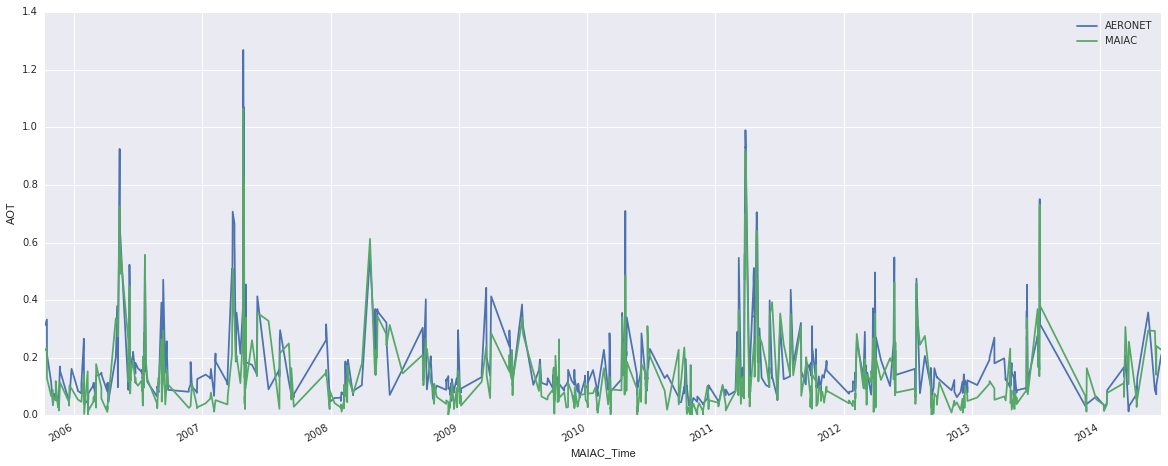

In [47]:
Chilbolton_result.plot(figsize=(20, 8))
plt.ylabel('AOT')
plt.savefig(r'D:\Annies_Dissertation\Analysis\Chil_validation_graph.jpeg')

In [50]:
Chilbolton_result['error'] = Chilbolton_result['AERONET'] - Chilbolton_result['MAIAC']

In [51]:
Chilbolton_result.error.abs().describe()

count    869.000000
mean       0.067193
std        0.051317
min        0.000234
25%        0.030522
50%        0.058529
75%        0.089954
max        0.331584
Name: error, dtype: float64

In [29]:
Chilbolton_result.MAIAC.describe()

count    869.000000
mean       0.128092
std        0.135128
min        0.000000
25%        0.043000
50%        0.082000
75%        0.164000
max        1.066000
Name: MAIAC, dtype: float64

In [30]:
Chilbolton_result.AERONET.describe()

count    869.000000
mean       0.177500
std        0.154765
min        0.013683
25%        0.087325
50%        0.129031
75%        0.202441
max        1.268825
Name: AERONET, dtype: float64

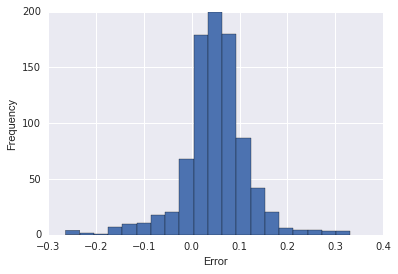

In [54]:
Chil_error_histo = Chilbolton_result.error.plot.hist(bins=20)
plt.xlabel('Error')
plt.savefig(r'D:\Annies_Dissertation\Methodology\Validation\AERONET\AERONET_error_histo.jpeg')

In [33]:
Chilbolton_result.to_csv(r'D:\Annies_Dissertation\Methodology\Validation\AERONET\Chil_validation.csv')

In [34]:
rmse = sqrt(mean_squared_error(y_true = Chilbolton_result.AERONET, y_pred = Chilbolton_result.MAIAC))
rmse

0.08452970527939516

In [35]:
me = mean_absolute_error(y_true = Chilbolton_result.AERONET, y_pred = Chilbolton_result.MAIAC)
me

0.06719297583429229

### Correlation and Regression

In [37]:
Chilbolton_result.corr()

,AERONET,MAIAC,error
AERONET,1.000000,0.896621,0.489700
MAIAC,0.896621,1.000000,0.053004
error,0.489700,0.053004,1.000000


In [38]:
slope, intercept, r_value, p_value, std_err = stats.linregress(Chilbolton_result.AERONET,Chilbolton_result.MAIAC)
print("r-squared:", r_value**2)
print("p-value:", p_value)
print("Slope:", slope)

r-squared: 0.803929721547
p-value: 5.50268726006e-309
Slope: 0.782856479788


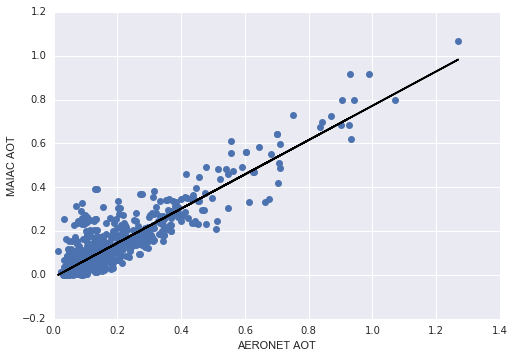

In [40]:
predict_y = intercept + slope * Chilbolton_result.AERONET

pylab.plot(Chilbolton_result.AERONET,Chilbolton_result.MAIAC, 'o')
pylab.plot(Chilbolton_result.AERONET, predict_y, 'k-')
pylab.xlabel('AERONET AOT')
pylab.ylabel('MAIAC AOT')
pylab.show()
pylab.savefig(r'D:\Annies_Dissertation\Methodology\Validation\AERONET\AERONET_error_regression.jpeg')